In [1]:
import argparse
import random

import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
args = {
    'seed': 1234,
    'n_epoch': 200,
    'n_batch': 2,
    'lr': 0.001,
    'save_path': '../data/model/p_sentence_classification.pth',
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
}
args = argparse.Namespace(**args)
print(args)

Namespace(seed=1234, n_epoch=200, n_batch=2, lr=0.001, save_path='../data/model/p_sentence_classification.pth', device=device(type='cuda'))


In [ ]:
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

In [3]:
raw_inputs = [
    '나는 학생 입니다.',
    '나는 선생님 입니다.',
    '당신은 좋은 선생님 입니다.'
]

raw_labels = [1, 0, 0]

In [10]:
# words
words = []
for s in raw_inputs:
    words.extend(s.split())
words = list(dict.fromkeys(words))
print(words)

# wti
word_to_id = {'[PAD]': 0, '[UNK]': 1}
for w in words:
    word_to_id[w] = len(word_to_id)
print(word_to_id)

# itw
id_to_word = {i: w for w, i in word_to_id.items()}
print(id_to_word)

['나는', '학생', '입니다.', '선생님', '당신은', '좋은']
{'[PAD]': 0, '[UNK]': 1, '나는': 2, '학생': 3, '입니다.': 4, '선생님': 5, '당신은': 6, '좋은': 7}
{0: '[PAD]', 1: '[UNK]', 2: '나는', 3: '학생', 4: '입니다.', 5: '선생님', 6: '당신은', 7: '좋은'}


In [16]:
inputs = []
for s in raw_inputs:
    inputs.append([word_to_id[w] for w in s.split()])
print(inputs)

labels = raw_labels
print(labels)

[[2, 3, 4], [2, 5, 4], [6, 7, 5, 4]]
[1, 0, 0]


In [18]:
class SimpleDataSet(torch.utils.data.Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels
    
    def __len__(self):
        assert len(self.inputs) == len(self.labels)
        return len(self.inputs)
    
    def __getitem__(self, index):
        return (
            torch.tensor(self.inputs[index]),
            torch.tensor(self.labels[index]),
        )
    
    def collate_fn(self, batch):
        # batch단위로 데이터 처리

        inputs, labels = list(zip(*batch))

        inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0)
        labels = torch.stack(labels)

        batch = [
            inputs,
            labels,
        ]

        return batch

In [19]:
dataset = SimpleDataSet(inputs, labels)
sampler = torch.utils.data.RandomSampler(dataset)

# 원래는 다른 dataset을 사용해야함
train_loader = torch.utils.data.DataLoader(dataset, batch_size=args.n_batch, collate_fn=dataset.collate_fn, sampler=sampler)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=args.n_batch, collate_fn=dataset.collate_fn)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=args.n_batch, collate_fn=dataset.collate_fn)

print(len(dataset))

3


In [22]:
t_inputs = torch.tensor(inputs[:1])
t_labels = torch.tensor(labels[:1])
print(t_inputs, t_labels)

tensor([[2, 3, 4]]) tensor([1])


In [35]:
embed = torch.nn.Embedding(len(word_to_id), 10)
hidden = embed(t_inputs)
print(hidden.shape, hidden)

hidden, _ = torch.max(hidden, dim=1)
print(hidden.shape, hidden)

linear = torch.nn.Linear(10, 2)
logits = linear(hidden)
print(logits.shape, logits)

loss_fn = torch.nn.CrossEntropyLoss()
loss = loss_fn(logits.view(-1, logits.size(-1)), t_labels.view(-1))
print(loss)


torch.Size([1, 3, 10]) tensor([[[-0.5138,  1.1776,  1.0542, -0.8216, -0.7140, -1.0227, -0.5422,
           0.2212, -0.7700, -0.1974],
         [ 0.0383,  0.0119, -0.2980,  0.2182, -1.6763,  0.5824,  1.6759,
           0.7911, -0.5330, -0.3713],
         [-0.5541, -1.7607, -0.4980,  0.6556, -0.5972,  0.7850,  0.5609,
          -0.8100, -1.5659, -0.2181]]], grad_fn=<EmbeddingBackward0>)
torch.Size([1, 10]) tensor([[ 0.0383,  1.1776,  1.0542,  0.6556, -0.5972,  0.7850,  1.6759,  0.7911,
         -0.5330, -0.1974]], grad_fn=<MaxBackward0>)
torch.Size([1, 2]) tensor([[0.8738, 1.0231]], grad_fn=<AddmmBackward0>)
tensor(0.6213, grad_fn=<NllLossBackward0>)


In [36]:
class SentenceClassificationModel(torch.nn.Module):
    def __init__(self, n_vocab):
        super().__init__()
        # embedding layer dim = 10
        # class = 2
        self.embed = torch.nn.Embedding(n_vocab, 10)
        self.linear = torch.nn.Linear(10, 2)

    def forward(self, inputs):
        hidden = self.embed(inputs)
        hidden, _ = torch.max(hidden, dim=1)
        logits = self.linear(hidden)
        return logits

In [37]:
model = SentenceClassificationModel(len(word_to_id))
model.to(device=args.device)
print(model)


SentenceClassificationModel(
  (embed): Embedding(8, 10)
  (linear): Linear(in_features=10, out_features=2, bias=True)
)


In [38]:
def accuracy_fn(logits, labels):
    _, indices = logits.max(-1)

    matchs = torch.eq(indices, labels).cpu().numpy()
    total = np.ones_like(matchs)
    acc_val = np.sum(matchs) / max(1, np.sum(total))
    return acc_val

In [41]:
def train_epoch(model: torch.nn.Module, args, loader: torch.utils.data.DataLoader, loss_fn, optimizer: torch.optim.Optimizer):
    model.train()
    losses, acces = [], []

    for batch in loader:
        optimizer.zero_grad()
        inputs, labels = map(lambda v: v.to(args.device), batch)
        logits = model(inputs)
        loss = loss_fn(logits.view(-1, logits.size(-1)) , labels.view(-1))
        loss.backward()

        optimizer.step()
        loss_val = loss.item()
        losses.append(loss_val)

        acc_val = accuracy_fn(logits, labels)
        acces.append(acc_val)
    
    return np.mean(losses), np.mean(acces)

In [43]:
def eval_epoch(model: torch.nn.Module, args, loader: torch.utils.data.DataLoader, loss_fn):
    model.eval()
    losses, acces = [], []

    with torch.no_grad():
        for batch in loader:
            inputs, labels = map(lambda v: v.to(args.device), batch)
            logits = model(inputs)
            loss = loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1))
            
            loss_val = loss.item()
            losses.append(loss_val)

            acc_val = accuracy_fn(logits, labels)
            acces.append(acc_val)
    
    return np.mean(losses), np.mean(acces)

In [46]:
def draw_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], "b-", label="train_loss")
    plt.plot(history["valid_loss"], "r--", label="valid_loss")
    plt.xlabel("Epoch")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], "k--", label="train_acc")
    plt.plot(history["valid_acc"], "k--", label="valid_acc")
    plt.xlabel("Epoch")
    plt.legend()

    plt.show()

In [45]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
history = {'train_loss': [], 'train_acc': [], 'valid_loss': [], 'valid_acc': []}
best_acc = 0

for e in range(args.n_epoch):
    train_loss, train_acc = train_epoch(model, args, train_loader, loss_fn, optimizer)
    valid_loss, valid_acc = eval_epoch(model, args, valid_loader, loss_fn)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["valid_loss"].append(valid_loss)
    history["valid_acc"].append(valid_acc)
    print(f"eopch: {e + 1:3d}, train_loss: {train_loss:.5f}, train_acc: {train_acc: .5f}, valid_loss: {valid_loss:.5f}, valid_acc: {valid_acc:.5f}")
    
    if best_acc < valid_acc:
        best_acc = valid_acc
        torch.save({"state_dict": model.state_dict(), "valid_acc": valid_acc}, args.save_path)
        print(f"  >> save weights: {args.save_path}")


eopch:   1, train_loss: 1.05911, train_acc:  0.50000, valid_loss: 1.30652, valid_acc: 0.25000
  >> save weights: ../data/model/p_sentence_classification.pth
eopch:   2, train_loss: 1.30158, train_acc:  0.25000, valid_loss: 1.29071, valid_acc: 0.25000
eopch:   3, train_loss: 1.03939, train_acc:  0.50000, valid_loss: 1.27217, valid_acc: 0.25000
eopch:   4, train_loss: 1.26625, train_acc:  0.25000, valid_loss: 1.25547, valid_acc: 0.25000
eopch:   5, train_loss: 1.02173, train_acc:  0.50000, valid_loss: 1.23746, valid_acc: 0.25000
eopch:   6, train_loss: 1.01250, train_acc:  0.50000, valid_loss: 1.22141, valid_acc: 0.25000
eopch:   7, train_loss: 1.21600, train_acc:  0.25000, valid_loss: 1.20637, valid_acc: 0.25000
eopch:   8, train_loss: 1.11362, train_acc:  0.25000, valid_loss: 1.18944, valid_acc: 0.25000
eopch:   9, train_loss: 0.98943, train_acc:  0.50000, valid_loss: 1.17213, valid_acc: 0.25000
eopch:  10, train_loss: 0.98092, train_acc:  0.50000, valid_loss: 1.15653, valid_acc: 0.250

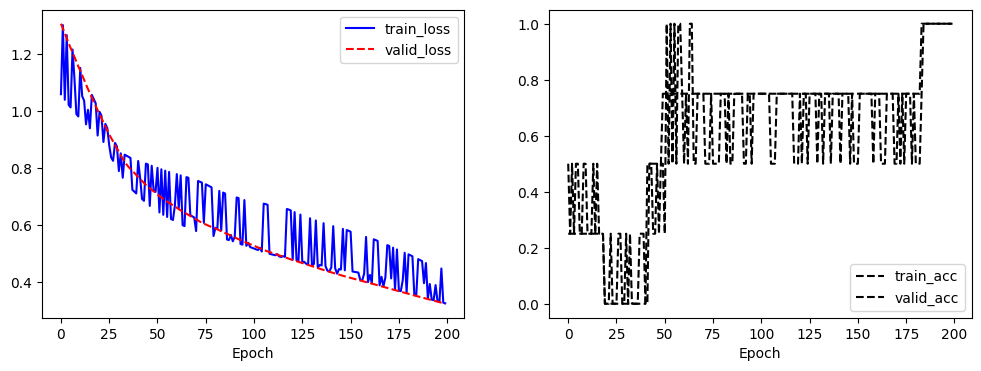

In [56]:
draw_history(history)

In [63]:
def do_predict(word_to_id, model, string):
    token = [(word_to_id[w] if w in word_to_id else word_to_id['[UNK]']) for w in string.strip().split()]

    model.eval()
    with torch.no_grad():
        inputs = torch.tensor([token]).to(args.device)
        logits = model(inputs)
        _, indices = logits.max(-1)
        y_pred = indices[0].to('cpu').numpy()
    
    result = '학생' if y_pred == 1 else '선생님'
    return result

In [66]:
# test and deploy
test_model = SentenceClassificationModel(len(word_to_id))
test_model.to(args.device)
print(test_model)

# random init
valid_loss, valid_acc = eval_epoch(test_model, args, test_loader, loss_fn)
print(valid_loss, valid_acc)

save_dict = torch.load(args.save_path)
print(save_dict)

test_model.load_state_dict(save_dict['state_dict'])

# best trained model
valid_loss, valid_acc = eval_epoch(test_model, args, test_loader, loss_fn)
print(valid_loss, valid_acc)


SentenceClassificationModel(
  (embed): Embedding(8, 10)
  (linear): Linear(in_features=10, out_features=2, bias=True)
)
0.5607838332653046 0.75
{'state_dict': OrderedDict([('embed.weight', tensor([[ 0.3081, -0.2607,  0.6032, -0.8612, -0.1111, -1.5715,  0.0548,  1.5374,
          0.3691, -1.2422],
        [-0.9213,  1.3117,  0.4434, -0.0452, -0.9789, -1.1211, -0.1296, -0.0182,
          0.5430, -2.0013],
        [-2.0482,  1.0742,  1.6725,  1.1544,  0.0116, -0.3220,  1.2534, -0.1753,
         -1.3598,  0.3148],
        [ 0.9796,  0.0106,  0.9365,  0.7050,  0.9805, -0.3236, -0.0805, -2.0644,
         -0.0716,  1.5417],
        [-1.3040, -0.6304, -0.4037,  0.0531,  2.5227, -0.9584,  0.8435, -0.7083,
         -0.3527, -0.3483],
        [ 0.9043, -1.6061,  0.9339, -0.2293,  0.3483, -1.3409, -2.9680,  1.3887,
          1.0632,  0.2279],
        [-0.3656,  0.3590, -0.0093,  0.4453, -1.5262,  1.0102,  0.1744,  0.1097,
         -0.3140, -0.9123],
        [ 1.5778,  1.5567, -0.2565,  1.0669,  0

In [65]:
print(do_predict(word_to_id, test_model, '학교에 학생이 있다.'))

선생님
